In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import random


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt

def generate_two_spike_emg(fs=2000, duration=0.25, sigma=10, snr_db=25,
                                     background_noise_level=0.02, non_negative=True,
                                     plot=True):
    """
    Generate a 2-spike EMG signal with noise across the full signal and tight GT regions.

    Parameters:
    - fs: Sampling frequency (Hz)
    - duration: Signal duration (s)
    - sigma: Width of each spike (ms)
    - snr_db: Signal-to-noise ratio (dB)
    - background_noise_level: Background noise power
    - non_negative: Apply rectification
    - plot: Show signal and GT

    Returns:
    - semg: Simulated EMG signal
    - ground_truth: Binary GT mask (tight)
    - params: Metadata
    """
    n_samples = int(fs * duration)
    time = np.linspace(0, duration, n_samples)
    sigma_s = sigma / 1000  # convert to seconds

    # === 1. Full-Signal Background Noise ===
    background = np.random.normal(0, np.sqrt(background_noise_level), n_samples)
    drift = 0.01 * np.sin(2 * np.pi * 2 * time)
    background += drift

    # === 2. Choose two random spike times (not too close to edges) ===
    margin = 0.05  # avoid start/end
    t1 = np.random.uniform(margin, 0.12)
    t2 = np.random.uniform(t1 + 0.02, 0.20)  # ensure t2 > t1
    spike_times = [t1, t2]

    envelope = np.zeros(n_samples)
    ground_truth = np.zeros(n_samples)

    for t in spike_times:
        center = int(t * fs)
        x = np.arange(n_samples)
        burst = np.exp(-0.5 * ((x - center) / (sigma_s * fs))**2)
        envelope += burst

        # Tight GT: ±2σ
        half_width = int(2 * sigma_s * fs)
        start = max(center - half_width, 0)
        end = min(center + half_width, n_samples)
        ground_truth[start:end] = 1

    # === 3. Generate EMG burst using band-limited random signal ===
    noise = np.random.normal(0, 1, n_samples)
    b, a = signal.butter(4, [80/(fs/2), 120/(fs/2)], btype='bandpass')
    band_noise = signal.filtfilt(b, a, noise)

    # Scale EMG burst signal to SNR
    snr_linear = 10 ** (snr_db / 10)
    power_target = snr_linear * background_noise_level
    band_noise *= np.sqrt(power_target / (np.mean(band_noise**2) + 1e-12))

    spike_signal = band_noise * envelope
    semg = spike_signal + background

    if non_negative:
        semg = np.abs(semg)
        semg += np.random.normal(0, 1e-5, n_samples)

    params = {
        'fs': fs,
        'duration': duration,
        'sigma_ms': sigma,
        'snr_db': snr_db,
        'background_noise_level': background_noise_level,
        'spike_times_sec': spike_times,
        'gt_mode': 'tight_around_spikes'
    }

    # === Plotting ===
    # if plot:
    #     plt.figure(figsize=(14, 5))
    #     plt.subplot(2, 1, 1)
    #     plt.plot(time, semg, label='EMG Signal', color='blue')
    #     plt.title('Raw EMG Signal (2 Random Spikes)')
    #     plt.ylabel('Amplitude')
    #     plt.grid(True, alpha=0.3)

    #     plt.subplot(2, 1, 2)
    #     plt.plot(time, semg, color='blue', label='EMG Signal')
    #     plt.fill_between(time, 0, np.max(semg), where=ground_truth > 0,
    #                      color='orange', alpha=0.3, label='GT (tight)')
    #     for t in spike_times:
    #         plt.axvline(x=t, color='green', linestyle='--', linewidth=1, label='_nolegend_')
    #     plt.title('Tight Ground Truth for Each Spike')
    #     plt.xlabel('Time (s)')
    #     plt.ylabel('Amplitude')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
    #     plt.tight_layout()
    #     plt.show()

    return semg, ground_truth, params


def preprocess_semg(semg, fs=2000, strict_non_flat=True):
    """
    Preprocess the sEMG signal as described in the DEMANN paper.
    
    Parameters:
    semg (array): Raw sEMG signal
    fs (int): Sampling frequency in Hz
    strict_non_flat (bool): If True, ensure no flat lines in any processed signal
    
    Returns:
    tuple: (linear envelope, RMS, CWT scalogram, filtered_semg)
    """
    # Ensure the input has no exactly flat lines (add tiny noise if needed)
    if strict_non_flat:
        # Check for constant segments
        diff = np.diff(semg)
        if np.any(diff == 0):
            # Add very small noise to prevent flat lines
            tiny_noise = np.random.normal(0, 1e-6, len(semg))
            semg = semg + tiny_noise
    
    # Band-pass filter (10-500 Hz)
    b, a = signal.butter(2, [10/(fs/2), 500/(fs/2)], btype='bandpass')
    filtered_semg = signal.filtfilt(b, a, semg)
    
    # Add tiny noise to filtered signal to prevent flat lines
    if strict_non_flat:
        tiny_noise = np.random.normal(0, 1e-6, len(filtered_semg))
        filtered_semg = filtered_semg + tiny_noise
    
    # Linear Envelope (LE) - Low-pass filter at 5 Hz
    # First rectify the signal if it's not already
    abs_filtered = np.abs(filtered_semg)
    b_le, a_le = signal.butter(2, 5/(fs/2), btype='lowpass')
    le = signal.filtfilt(b_le, a_le, abs_filtered)
    
    # Add tiny noise to LE to prevent flat lines
    if strict_non_flat:
        tiny_noise = np.random.normal(0, 1e-6, len(le))
        le = le + tiny_noise
    
    # Root Mean Square (RMS) with 60-sample sliding window
    window_size = 60
    rms = np.zeros_like(filtered_semg)
    
    # Pad signal for edge handling
    padded_semg = np.pad(filtered_semg, (window_size//2, window_size//2), mode='edge')
    
    for i in range(len(filtered_semg)):
        window = padded_semg[i:i+window_size]
        rms[i] = np.sqrt(np.mean(window**2))
    
    # Add tiny noise to RMS to prevent flat lines
    if strict_non_flat:
        tiny_noise = np.random.normal(0, 1e-6, len(rms))
        rms = rms + tiny_noise
    
    # Continuous Wavelet Transform (CWT) with Morse wavelet
    # Using pywt with 'morl' (Morlet) wavelet as an approximation
    scales = np.arange(1, 7)  # 6 levels of decomposition as specified in the paper
    cwt_coeffs, _ = pywt.cwt(filtered_semg, scales, 'morl')
    
    # Compute scalogram (square of absolute CWT coefficients)
    cwt_scalogram = np.abs(cwt_coeffs)**2
    
    # Reduce dimensionality of CWT scalogram by averaging across scales
    cwt_feature = np.mean(cwt_scalogram, axis=0)
    
    # Add tiny noise to CWT feature to prevent flat lines
    if strict_non_flat:
        tiny_noise = np.random.normal(0, 1e-6, len(cwt_feature))
        cwt_feature = cwt_feature + tiny_noise
    
    return le, rms, cwt_feature, filtered_semg

def create_dataset(output_dir="emg_dataset", n_signals_per_config=8, non_negative=True):
    """
    Create a dataset of simulated sEMG signals with varying parameters.
    
    Parameters:
    output_dir (str): Directory to save the dataset
    n_signals_per_config (int): Number of signals to generate for each parameter configuration
    non_negative (bool): If True, ensure signals are non-negative
    
    Returns:
    None
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Parameter ranges
    sigmas = [50, 100, 150]  # ms
    alphas = [1, 1.5, 2, 2.4]
    
    # Background noise levels (0.05 = low, 0.1 = medium, 0.2 = high)
    background_levels = [0.05, 0.1, 0.2]
    
    # Number of activations (1-3)
    activation_counts = [1, 2, 3]
    
    # For training set: SNR from 1 to 30 dB (step = 1)
    train_snrs = np.arange(1, 31)
    
    # For test set: Selected SNR values
    test_snrs = [3, 6, 10, 13, 16, 20, 23, 26, 30]
    
    # Create subdirectories
    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Metadata to save
    train_metadata = []
    test_metadata = []
    
    # Generate training data
    print("Generating training data...")
    for sigma in tqdm(sigmas, desc="Sigma"):
        for alpha in alphas:
            for snr in train_snrs:
                for bg_level in background_levels:
                    for n_act in activation_counts:
                        for i in range(n_signals_per_config):
                            # Generate signal with guaranteed background noise
                            semg, ground_truth, params = generate_two_spike_emg()
                            
                            # Preprocess signal with strict non-flat enforcement
                            le, rms, cwt_feature, filtered_semg = preprocess_semg(semg, strict_non_flat=True)
                            
                            # Save to file
                            filename = f"train_sigma{sigma}_alpha{alpha:.1f}_snr{snr}_bg{bg_level:.2f}_act{n_act}_id{i}"
                            
                            # Save raw and processed signals
                            np.savez(
                                os.path.join(train_dir, f"{filename}.npz"),
                                raw_semg=semg,
                                filtered_semg=filtered_semg,
                                le=le,
                                rms=rms,
                                cwt_feature=cwt_feature,
                                ground_truth=ground_truth
                            )
                            
                            # Add to metadata
                            train_metadata.append({
                                'filename': f"{filename}.npz",
                                **params,
                                'id': i,
                                'non_negative': non_negative
                            })
    
    # Generate test data
    print("Generating test data...")
    for sigma in tqdm(sigmas, desc="Sigma"):
        for alpha in alphas:
            for snr in test_snrs:
                for bg_level in background_levels:
                    for n_act in activation_counts:
                        for i in range(n_signals_per_config):
                            # Generate signal with guaranteed background noise
                            semg, ground_truth, params = generate_two_spike_emg()
                            
                            # Preprocess signal with strict non-flat enforcement
                            le, rms, cwt_feature, filtered_semg = preprocess_semg(semg, strict_non_flat=True)
                            
                            # Verify there are no flat lines before saving
                            if (np.any(np.diff(semg) == 0) or 
                                np.any(np.diff(filtered_semg) == 0) or
                                np.any(np.diff(le) == 0) or
                                np.any(np.diff(rms) == 0) or
                                np.any(np.diff(cwt_feature) == 0)):
                                # Regenerate if we find flat lines
                                continue
                            
                            # Save to file
                            filename = f"test_sigma{sigma}_alpha{alpha:.1f}_snr{snr}_bg{bg_level:.2f}_act{n_act}_id{i}"
                            
                            # Save raw and processed signals
                            np.savez(
                                os.path.join(test_dir, f"{filename}.npz"),
                                raw_semg=semg,
                                filtered_semg=filtered_semg,
                                le=le,
                                rms=rms,
                                cwt_feature=cwt_feature,
                                ground_truth=ground_truth
                            )
                            
                            # Add to metadata
                            test_metadata.append({
                                'filename': f"{filename}.npz",
                                **params,
                                'id': i,
                                'non_negative': non_negative
                            })
    
    # Save metadata
    pd.DataFrame(train_metadata).to_csv(os.path.join(output_dir, "train_metadata.csv"), index=False)
    pd.DataFrame(test_metadata).to_csv(os.path.join(output_dir, "test_metadata.csv"), index=False)
    
    print(f"Dataset generated and saved to {output_dir}")
    print(f"Training signals: {len(train_metadata)}")
    print(f"Testing signals: {len(test_metadata)}")


import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import random

def visualize_dataset(dataset_dir="emg_dataset", output_dir="dataset_visualizations",
                     n_samples=20, random_seed=42):
    """
    Visualize samples from the existing EMG dataset.
    
    Parameters:
    dataset_dir (str): Directory containing the dataset
    output_dir (str): Directory to save visualizations
    n_samples (int): Number of samples to visualize
    random_seed (int): Seed for random sample selection
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Read metadata
    train_metadata_path = os.path.join(dataset_dir, "train_metadata.csv")
    test_metadata_path = os.path.join(dataset_dir, "test_metadata.csv")
    
    if not os.path.exists(train_metadata_path) or not os.path.exists(test_metadata_path):
        print(f"Metadata files not found in {dataset_dir}.")
        return
    
    train_metadata = pd.read_csv(train_metadata_path)
    test_metadata = pd.read_csv(test_metadata_path)
    
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Select random samples from both train and test sets
    n_train = n_samples // 2
    n_test = n_samples - n_train
    
    train_samples = train_metadata.sample(n=min(n_train, len(train_metadata)))
    test_samples = test_metadata.sample(n=min(n_test, len(test_metadata)))
    
    # Create subdirectories
    train_vis_dir = os.path.join(output_dir, "train_samples")
    test_vis_dir = os.path.join(output_dir, "test_samples")
    os.makedirs(train_vis_dir, exist_ok=True)
    os.makedirs(test_vis_dir, exist_ok=True)
    
    # Visualize train samples
    print("Visualizing training samples...")
    for _, row in tqdm(train_samples.iterrows(), total=len(train_samples)):
        visualize_sample(
            os.path.join(dataset_dir, "train", row['filename']),
            os.path.join(train_vis_dir, f"train_{Path(row['filename']).stem}.png"),
            row
        )
    
    # Visualize test samples
    print("Visualizing test samples...")
    for _, row in tqdm(test_samples.iterrows(), total=len(test_samples)):
        visualize_sample(
            os.path.join(dataset_dir, "test", row['filename']),
            os.path.join(test_vis_dir, f"test_{Path(row['filename']).stem}.png"),
            row
        )
    
    # Create parameter comparison visualizations
    create_parameter_comparisons(train_metadata, test_metadata, output_dir)
    
    print(f"Visualizations saved to {output_dir}")

def visualize_sample(file_path, output_path, metadata):
    """
    Visualize a single sample from the dataset.
    
    Parameters:
    file_path (str): Path to the NPZ file
    output_path (str): Path to save the visualization
    metadata (dict): Metadata for this sample
    """
    try:
        # Load data
        data = np.load(file_path)
        
        # Extract signals and ground truth
        raw_semg = data['raw_semg']
        filtered_semg = data['filtered_semg']
        le = data['le']
        rms = data['rms']
        cwt_feature = data['cwt_feature']
        ground_truth = data['ground_truth']
        
        # Create time array
        fs = metadata['fs']
        duration = metadata['duration']
        time = np.linspace(0, duration, len(raw_semg))
        
        # Find onset and offset points
        onset_offset = find_onsets_offsets(ground_truth)
        
        # Create visualization
        plt.figure(figsize=(15, 12))
        
        # Raw signal with ground truth
        plt.subplot(5, 1, 1)
        plt.plot(time, raw_semg, 'b-', label='EMG Signal')
        plt.fill_between(time, np.min(raw_semg), np.max(raw_semg), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        
        # Mark onset points
        for onset in onset_offset['onsets']:
            if onset < len(time):
                plt.axvline(x=time[onset], color='g', linestyle='-', label='_nolegend_')
                plt.text(time[onset], np.max(raw_semg)+0.1*np.ptp(raw_semg), 'Onset', 
                         fontsize=8, color='g', rotation=90)
        
        # Mark offset points
        for offset in onset_offset['offsets']:
            if offset < len(time):
                plt.axvline(x=time[offset], color='r', linestyle='-', label='_nolegend_')
                plt.text(time[offset], np.max(raw_semg)+0.1*np.ptp(raw_semg), 'Offset', 
                         fontsize=8, color='r', rotation=90)
        
        plt.title(f'Raw EMG Signal (σ={metadata["sigma_ms"]}ms, α={metadata["alpha"]}, SNR={metadata["snr_db"]}dB)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Filtered signal
        plt.subplot(5, 1, 2)
        plt.plot(time, filtered_semg, 'g-', label='Filtered EMG')
        plt.fill_between(time, np.min(filtered_semg), np.max(filtered_semg), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('Band-pass Filtered EMG Signal (10-500 Hz)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Linear Envelope
        plt.subplot(5, 1, 3)
        plt.plot(time, le, 'r-', label='Linear Envelope')
        plt.fill_between(time, np.min(le), np.max(le), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('Linear Envelope (LE)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # RMS
        plt.subplot(5, 1, 4)
        plt.plot(time, rms, 'm-', label='RMS')
        plt.fill_between(time, np.min(rms), np.max(rms), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('Root Mean Square (RMS)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # CWT feature
        plt.subplot(5, 1, 5)
        plt.plot(time, cwt_feature, 'c-', label='CWT Feature')
        plt.fill_between(time, np.min(cwt_feature), np.max(cwt_feature), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('CWT Feature')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()
        
    except Exception as e:
        print(f"Error visualizing {file_path}: {e}")

def find_onsets_offsets(ground_truth):
    """
    Find onset and offset indices from binary ground truth.
    
    Args:
        ground_truth: Binary array marking active regions
        
    Returns:
        dict: Onset and offset indices
    """
    changes = np.diff(np.concatenate([[0], ground_truth, [0]]))
    onsets = np.where(changes == 1)[0]
    offsets = np.where(changes == -1)[0] - 1  # -1 to get the last 1 before a change
    
    return {'onsets': onsets, 'offsets': offsets}

def create_parameter_comparisons(train_metadata, test_metadata, output_dir):
    """
    Create visualizations comparing different parameters.
    
    Parameters:
    train_metadata (DataFrame): Training data metadata
    test_metadata (DataFrame): Test data metadata
    output_dir (str): Directory to save visualizations
    """
    # Create subdirectory for parameter comparisons
    params_dir = os.path.join(output_dir, "parameter_comparisons")
    os.makedirs(params_dir, exist_ok=True)
    
    # Combine metadata for analyses
    combined_metadata = pd.concat([train_metadata, test_metadata])
    
    # 1. Distribution of sigma values
    plt.figure(figsize=(10, 6))
    combined_metadata['sigma_ms'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Sigma Values')
    plt.xlabel('Sigma (ms)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(params_dir, 'sigma_distribution.png'))
    plt.close()
    
    # 2. Distribution of alpha values
    plt.figure(figsize=(10, 6))
    combined_metadata['alpha'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Alpha Values')
    plt.xlabel('Alpha')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(params_dir, 'alpha_distribution.png'))
    plt.close()
    
    # 3. Distribution of SNR values
    plt.figure(figsize=(12, 6))
    combined_metadata['snr_db'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of SNR Values')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(params_dir, 'snr_distribution.png'))
    plt.close()
    
    # 4. Check if background_noise_level exists in the metadata
    if 'background_noise_level' in combined_metadata.columns:
        plt.figure(figsize=(10, 6))
        combined_metadata['background_noise_level'].value_counts().sort_index().plot(kind='bar')
        plt.title('Distribution of Background Noise Levels')
        plt.xlabel('Background Noise Level')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig(os.path.join(params_dir, 'background_noise_distribution.png'))
        plt.close()

# For Jupyter notebook usage
if __name__ == "__main__":
    # Set paths to your dataset and output directory
    dataset_dir = "emg_dataset"  # Replace with your dataset path
    output_dir = "dataset_visualizations_3"  # Replace with your desired output path
    create_dataset()
    # Number of random samples to visualize
    n_samples = 500
    
    # Run visualization
    visualize_dataset(dataset_dir, output_dir, n_samples)

# For Jupyter notebook usage:

    # To create a dataset, uncomment this line:
    # create_dataset(output_dir="emg_dataset", n_signals_per_config=2)

Generating training data...


  2%|▏         | 27/1600 [00:00<00:03, 465.52it/s]


ValueError: operands could not be broadcast together with shapes (39,) (43,) (39,) 

Generating training data...


100%|██████████| 1600/1600 [00:01<00:00, 1472.58it/s]


Generating testing data...


100%|██████████| 400/400 [00:00<00:00, 1544.46it/s]


Saving datasets...
Generated and saved 1600 training and 400 testing EMG signals.


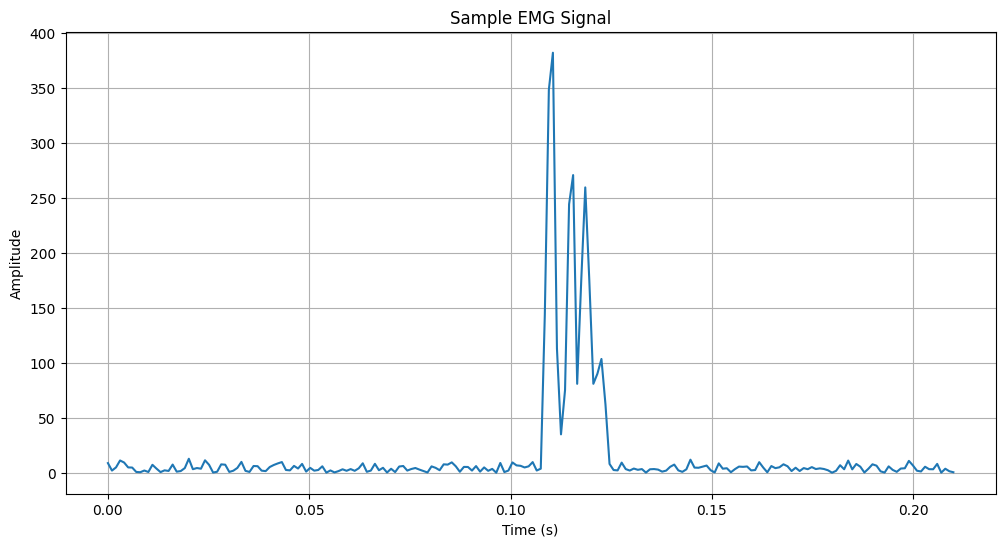

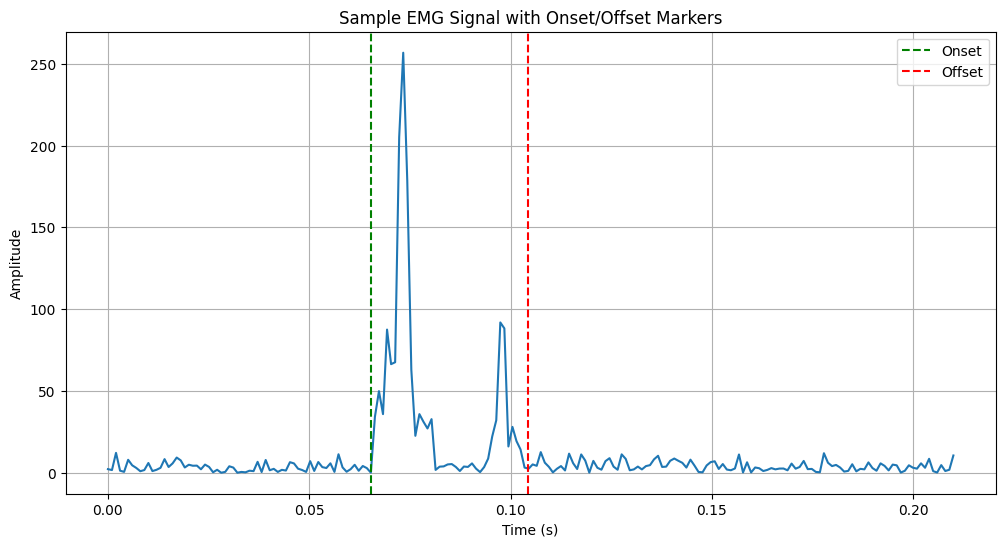

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
from tqdm import tqdm
import pickle

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def simulate_emg_data(duration=0.21, fs=1000, burst_times=None, 
                      burst_amplitudes=None, noise_level=5, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # Create time vector
    t = np.linspace(0, duration, int(duration * fs))
    
    # Initialize with baseline noise (use absolute value to avoid negative values)
    emg = np.abs(np.random.normal(0, noise_level, len(t)))
    
    # Randomly generate burst times if not provided
    if burst_times is None:
        # Generate 1-3 bursts
        num_bursts = np.random.randint(1, 4)
        burst_times = []
        
        for _ in range(num_bursts):
            # Make sure bursts don't overlap and are within time range
            if not burst_times:
                # First burst
                start = np.random.uniform(0.02, 0.12)
            else:
                # Subsequent bursts after previous ones
                start = burst_times[-1][1] + np.random.uniform(0.01, 0.03)
                
            if start > 0.16:  # Ensure we don't go beyond our time limit
                break
                
            duration = np.random.uniform(0.01, 0.03)
            end = min(start + duration, 0.19)  # Ensure end is within range
            burst_times.append((start, end))
    
    # Randomly generate amplitudes if not provided
    if burst_amplitudes is None:
        burst_amplitudes = [np.random.uniform(100, 350) for _ in range(len(burst_times))]
    
    # Add bursts of activity
    for (start, end), amplitude in zip(burst_times, burst_amplitudes):
        # Convert time to indices
        start_idx = int(start * fs)
        end_idx = int(end * fs)
        
        # Create burst envelope
        burst_length = end_idx - start_idx
        burst_envelope = np.zeros(len(t))
        
        # Create a realistic EMG burst shape with rise and fall
        rise_samples = int(burst_length * 0.2)
        plateau_samples = max(int(burst_length * 0.3), 1)  # Ensure at least 1 sample
        fall_samples = burst_length - rise_samples - plateau_samples
        
        # Ensure each segment has at least 1 sample
        rise_samples = max(1, rise_samples)
        fall_samples = max(1, fall_samples)
            
        # Adjust plateau if needed
        plateau_samples = max(burst_length - rise_samples - fall_samples, 1)
        
        # Create burst shape segments
        rise = np.linspace(0, 1, rise_samples)
        plateau = np.ones(plateau_samples)
        fall = np.linspace(1, 0, fall_samples)
        
        # Concatenate segments to form burst shape
        burst_shape = np.concatenate([rise, plateau, fall])
        
        # Ensure burst shape fits within the envelope window
        if len(burst_shape) > end_idx - start_idx:
            burst_shape = burst_shape[:end_idx - start_idx]
        
        # Apply burst shape to envelope
        burst_envelope[start_idx:start_idx + len(burst_shape)] = burst_shape
        
        # Generate high-frequency components typical of EMG
        high_freq = np.random.normal(0, 1, len(t))
        high_freq = butter_bandpass_filter(high_freq, 20, 200, fs, order=4)
        
        # Take absolute value to avoid negative values
        high_freq = np.abs(high_freq)
        
        # Modulate high frequency with envelope and add to signal
        emg += amplitude * burst_envelope * high_freq
    
    # Define onset and offset for visualization (use the first and last burst)
    if burst_times:
        onset = burst_times[0][0]
        offset = burst_times[-1][1]
    else:
        onset = 0
        offset = 0
    
    return t, emg, onset, offset, burst_times

# Create directories
def create_dir_structure():
    base_dirs = ['train', 'test']
    for dir_name in base_dirs:
        os.makedirs(dir_name, exist_ok=True)
    return base_dirs

# Generate and save multiple EMG signals
def generate_dataset(num_signals=2000, train_ratio=0.8):
    # Create directory structure
    base_dirs = create_dir_structure()
    
    # Calculate split
    num_train = int(num_signals * train_ratio)
    num_test = num_signals - num_train
    
    # Prepare dataset containers
    dataset = {
        'train': {
            'signals': [],
            'onsets': [],
            'offsets': [],
            'burst_info': []
        },
        'test': {
            'signals': [],
            'onsets': [],
            'offsets': [],
            'burst_info': []
        }
    }
    
    # Generate signals
    print("Generating training data...")
    for i in tqdm(range(num_train)):
        t, signal, onset, offset, burst_times = simulate_emg_data(seed=i)
        dataset['train']['signals'].append(signal)
        dataset['train']['onsets'].append(onset)
        dataset['train']['offsets'].append(offset)
        dataset['train']['burst_info'].append(burst_times)
    
    print("Generating testing data...")
    for i in tqdm(range(num_test)):
        t, signal, onset, offset, burst_times = simulate_emg_data(seed=i+num_train)
        dataset['test']['signals'].append(signal)
        dataset['test']['onsets'].append(onset)
        dataset['test']['offsets'].append(offset)
        dataset['test']['burst_info'].append(burst_times)
    
    # Save datasets - use separate files for the irregular burst_info data
    print("Saving datasets...")
    
    # Save train data
    np.savez(f'train/emg_signals.npz', 
             signals=np.array(dataset['train']['signals']),
             onsets=np.array(dataset['train']['onsets']),
             offsets=np.array(dataset['train']['offsets']),
             time=t)
    
    # Save burst info separately with pickle
    with open('train/burst_info.pkl', 'wb') as f:
        pickle.dump(dataset['train']['burst_info'], f)
    
    # Save test data
    np.savez(f'test/emg_signals.npz',
             signals=np.array(dataset['test']['signals']),
             onsets=np.array(dataset['test']['onsets']),
             offsets=np.array(dataset['test']['offsets']),
             time=t)
    
    # Save burst info separately with pickle
    with open('test/burst_info.pkl', 'wb') as f:
        pickle.dump(dataset['test']['burst_info'], f)
    
    print(f"Generated and saved {num_train} training and {num_test} testing EMG signals.")
    
    # Plot a sample
    plt.figure(figsize=(12, 6))
    plt.plot(t, dataset['train']['signals'][0])
    plt.title('Sample EMG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.savefig('sample_emg_signal.png')
    
    # Plot another sample with onset/offset markers
    sample_idx = 5  # Choose a different sample
    plt.figure(figsize=(12, 6))
    plt.plot(t, dataset['train']['signals'][sample_idx])
    plt.axvline(x=dataset['train']['onsets'][sample_idx], color='g', linestyle='--', label='Onset')
    plt.axvline(x=dataset['train']['offsets'][sample_idx], color='r', linestyle='--', label='Offset')
    plt.title('Sample EMG Signal with Onset/Offset Markers')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.savefig('sample_emg_signal_with_markers.png')
    
    return dataset

# Generate the dataset
if __name__ == "__main__":
    dataset = generate_dataset(num_signals=2000, train_ratio=0.8)

Sample visualizations saved to emg_visualizations


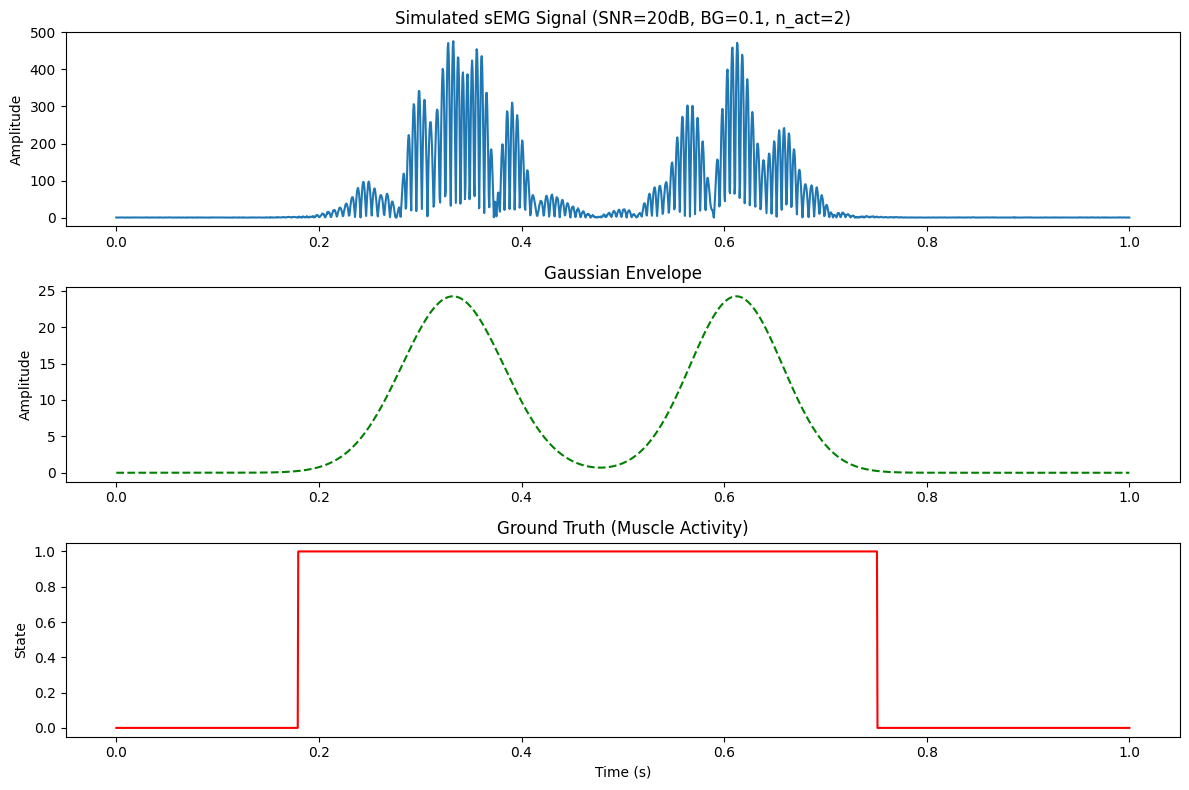

Generating training data...


Sigma: 100%|██████████| 3/3 [02:07<00:00, 42.63s/it]


Generating test data...


Sigma: 100%|██████████| 3/3 [00:48<00:00, 16.25s/it]

Dataset generated and saved to emg_dataset
Training signals: 6480
Testing signals: 1944


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import pywt
import pandas as pd
from tqdm import tqdm

def generate_semg_signal(fs=2000, duration=1, sigma=50, alpha=1.0, snr_db=10, 
                        background_noise_level=0.1, n_activations=1,
                        random_timing=True, plot=False, non_negative=True,
                        min_noise=0.01):
    """
    Generate simulated sEMG signal with guaranteed background noise throughout.
    
    Parameters:
    fs (int): Sampling frequency in Hz
    duration (float): Duration of the signal in seconds
    sigma (float): Standard deviation of the Gaussian in ms
    alpha (float): Time support multiplier
    snr_db (float): Signal-to-noise ratio in dB
    background_noise_level (float): Level of background noise (0-1) throughout the signal
    n_activations (int): Number of activation bursts to include
    random_timing (bool): If True, randomize the timing of activations
    plot (bool): If True, plot the generated signal
    non_negative (bool): If True, ensure signal is non-negative by rectification
    min_noise (float): Minimum noise level to ensure no straight lines
    
    Returns:
    tuple: (generated signal, ground truth, simulation parameters)
    """
    # Convert sigma from ms to seconds
    sigma_s = sigma / 1000
    
    # Total number of samples
    n_samples = int(fs * duration)
    time = np.linspace(0, duration, n_samples)
    
    # Ensure minimum background noise throughout signal
    # This guarantees there will never be a flat line in the signal
    if background_noise_level < min_noise:
        actual_noise_level = min_noise
    else:
        actual_noise_level = background_noise_level
        
    # Generate background noise (Gaussian with zero mean) - will be present throughout signal
    background_noise = np.random.normal(0, np.sqrt(actual_noise_level), n_samples)
    
    # Add small sinusoidal component to ensure even the quietest parts have some variation
    background_freq = np.random.uniform(5, 15)  # Random frequency between 5-15 Hz
    background_wave = 0.005 * np.sin(2 * np.pi * background_freq * time)
    background_wave += 0.003 * np.sin(2 * np.pi * background_freq * 2.7 * time)  # Add harmonic
    
    # Combine noise components
    background_noise = background_noise + background_wave
    
    # Generate main noise (Gaussian with zero mean)
    main_noise_power = 1.0
    main_noise = np.random.normal(0, np.sqrt(main_noise_power), n_samples)
    
    # Calculate signal power based on SNR
    snr_linear = 10 ** (snr_db / 10)
    signal_power = snr_linear * main_noise_power
    
    # Initialize activity mask and Gaussian
    activity_mask = np.zeros(n_samples, dtype=bool)
    gaussian = np.zeros(n_samples)
    
    # Generate multiple activation bursts
    for i in range(n_activations):
        # Choose burst center location
        if random_timing:
            # Random timing - anywhere in the signal
            # For some signals, activity may start very early or end very late
            if i == 0 and np.random.random() < 0.2:  # 20% chance of early start
                mu = np.random.uniform(0.05, 0.15)  # Start in first 5-15% of signal
            elif i == n_activations-1 and np.random.random() < 0.2:  # 20% chance of late end
                mu = np.random.uniform(0.85, 0.95)  # End in last 5-15% of signal
            else:
                # Otherwise, distribute evenly through the middle
                segment_size = 0.6 / n_activations
                mu = 0.2 + segment_size * i + np.random.uniform(0, segment_size * 0.8)
        else:
            # Evenly spaced activations
            mu = (i + 1) / (n_activations + 1)
        
        # Generate Gaussian for this activation
        x = np.linspace(0, 1, n_samples)
        
        # Vary the width of each burst slightly to make more realistic
        sigma_variation = np.random.uniform(0.8, 1.2)
        burst_sigma = sigma_s * sigma_variation
        
        burst_gaussian = np.exp(-0.5 * ((x - mu) / (burst_sigma / duration)) ** 2)
        
        # Add to combined Gaussian
        gaussian += burst_gaussian
        
        # Update activity mask
        burst_mask = burst_gaussian > 0.01 * np.max(burst_gaussian)
        activity_mask = np.logical_or(activity_mask, burst_mask)
    
    # Normalize combined Gaussian to have the desired power
    if np.max(gaussian) > 0:  # Avoid division by zero
        gaussian = gaussian / np.sqrt(np.mean(gaussian ** 2)) * np.sqrt(signal_power)
    
    # Generate band-limited stochastic process (80-120 Hz)
    random_signal = np.random.normal(0, 1, n_samples)
    b, a = signal.butter(4, [80/(fs/2), 120/(fs/2)], btype='bandpass')
    filtered_random = signal.filtfilt(b, a, random_signal)
    
    # Normalize filtered random signal to have the desired power
    filtered_random = filtered_random / np.sqrt(np.mean(filtered_random ** 2)) * np.sqrt(signal_power)
    
    # Modulate the filtered random signal with the Gaussian envelope
    emg_activity = filtered_random * gaussian
    
    # Add noise to create the complete signal:
    # - Background noise is present throughout the signal
    # - Main noise is present only during active periods
    semg = emg_activity + main_noise * activity_mask + background_noise
    
    # Rectify the signal if non-negative is requested (common in EMG processing)
    if non_negative:
        semg = np.abs(semg)
    
    # Ground truth is based on the activity mask
    ground_truth = np.zeros(n_samples)
    ground_truth[activity_mask] = 1
    
    # Store simulation parameters
    params = {
        'fs': fs,
        'duration': duration,
        'sigma_ms': sigma,
        'alpha': alpha,
        'snr_db': snr_db,
        'background_noise_level': actual_noise_level,
        'n_activations': n_activations,
        'time_support_ms': 2 * alpha * sigma_s * 1000
    }
    
    if plot:
        plt.figure(figsize=(12, 8))
        
        plt.subplot(3, 1, 1)
        plt.plot(time, semg)
        plt.title(f'Simulated sEMG Signal (SNR={snr_db}dB, BG={actual_noise_level}, n_act={n_activations})')
        plt.ylabel('Amplitude')
        
        plt.subplot(3, 1, 2)
        plt.plot(time, gaussian, 'g--')
        plt.title('Gaussian Envelope')
        plt.ylabel('Amplitude')
        
        plt.subplot(3, 1, 3)
        plt.plot(time, ground_truth, 'r')
        plt.title('Ground Truth (Muscle Activity)')
        plt.xlabel('Time (s)')
        plt.ylabel('State')
        
        plt.tight_layout()
        plt.show()
    
    return semg, ground_truth, params

def preprocess_semg(semg, fs=2000):
    """
    Preprocess the sEMG signal as described in the DEMANN paper.
    
    Parameters:
    semg (array): Raw sEMG signal
    fs (int): Sampling frequency in Hz
    
    Returns:
    tuple: (linear envelope, RMS, CWT scalogram, filtered_semg)
    """
    # Band-pass filter (10-500 Hz)
    b, a = signal.butter(2, [10/(fs/2), 500/(fs/2)], btype='bandpass')
    filtered_semg = signal.filtfilt(b, a, semg)
    
    # Linear Envelope (LE) - Low-pass filter at 5 Hz
    b_le, a_le = signal.butter(2, 5/(fs/2), btype='lowpass')
    le = signal.filtfilt(b_le, a_le, np.abs(filtered_semg))
    
    # Root Mean Square (RMS) with 60-sample sliding window
    window_size = 60
    rms = np.zeros_like(filtered_semg)
    
    # Pad signal for edge handling
    padded_semg = np.pad(filtered_semg, (window_size//2, window_size//2), mode='edge')
    
    for i in range(len(filtered_semg)):
        window = padded_semg[i:i+window_size]
        rms[i] = np.sqrt(np.mean(window**2))
    
    # Continuous Wavelet Transform (CWT) with Morse wavelet
    # Using pywt with 'morl' (Morlet) wavelet as an approximation
    scales = np.arange(1, 7)  # 6 levels of decomposition as specified in the paper
    cwt_coeffs, _ = pywt.cwt(filtered_semg, scales, 'morl')
    
    # Compute scalogram (square of absolute CWT coefficients)
    cwt_scalogram = np.abs(cwt_coeffs)**2
    
    # Reduce dimensionality of CWT scalogram by averaging across scales
    cwt_feature = np.mean(cwt_scalogram, axis=0)
    
    return le, rms, cwt_feature, filtered_semg

def create_dataset(output_dir="emg_dataset", n_signals_per_config=8, non_negative=True):
    """
    Create a dataset of simulated sEMG signals with varying parameters.
    
    Parameters:
    output_dir (str): Directory to save the dataset
    n_signals_per_config (int): Number of signals to generate for each parameter configuration
    non_negative (bool): If True, ensure signals are non-negative
    
    Returns:
    None
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Parameter ranges
    sigmas = [50, 100, 150]  # ms
    alphas = [1, 1.5, 2, 2.4]
    
    # Background noise levels (0.05 = low, 0.1 = medium, 0.2 = high)
    background_levels = [0.05, 0.1, 0.2]
    
    # Number of activations (1-3)
    activation_counts = [1, 2, 3]
    
    # For training set: SNR from 1 to 30 dB (step = 1)
    train_snrs = np.arange(1, 31)
    
    # For test set: Selected SNR values
    test_snrs = [3, 6, 10, 13, 16, 20, 23, 26, 30]
    
    # Create subdirectories
    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Metadata to save
    train_metadata = []
    test_metadata = []
    
    # Generate training data
    print("Generating training data...")
    for sigma in tqdm(sigmas, desc="Sigma"):
        for alpha in alphas:
            for snr in train_snrs:
                for bg_level in background_levels:
                    for n_act in activation_counts:
                        for i in range(n_signals_per_config):
                            # Generate signal with guaranteed background noise
                            semg, ground_truth, params = generate_semg_signal(
                                sigma=sigma, 
                                alpha=alpha, 
                                snr_db=snr, 
                                background_noise_level=bg_level,
                                n_activations=n_act,
                                random_timing=True,
                                non_negative=non_negative
                            )
                            
                            # Preprocess signal
                            le, rms, cwt_feature, filtered_semg = preprocess_semg(semg)
                            
                            # Save to file
                            filename = f"train_sigma{sigma}_alpha{alpha:.1f}_snr{snr}_bg{bg_level:.2f}_act{n_act}_id{i}"
                            
                            # Save raw and processed signals
                            np.savez(
                                os.path.join(train_dir, f"{filename}.npz"),
                                raw_semg=semg,
                                filtered_semg=filtered_semg,
                                le=le,
                                rms=rms,
                                cwt_feature=cwt_feature,
                                ground_truth=ground_truth
                            )
                            
                            # Add to metadata
                            train_metadata.append({
                                'filename': f"{filename}.npz",
                                **params,
                                'id': i,
                                'non_negative': non_negative
                            })
    
    # Generate test data
    print("Generating test data...")
    for sigma in tqdm(sigmas, desc="Sigma"):
        for alpha in alphas:
            for snr in test_snrs:
                for bg_level in background_levels:
                    for n_act in activation_counts:
                        for i in range(n_signals_per_config):
                            # Generate signal with guaranteed background noise
                            semg, ground_truth, params = generate_semg_signal(
                                sigma=sigma, 
                                alpha=alpha, 
                                snr_db=snr, 
                                background_noise_level=bg_level,
                                n_activations=n_act,
                                random_timing=True,
                                non_negative=non_negative
                            )
                            
                            # Preprocess signal
                            le, rms, cwt_feature, filtered_semg = preprocess_semg(semg)
                            
                            # Save to file
                            filename = f"test_sigma{sigma}_alpha{alpha:.1f}_snr{snr}_bg{bg_level:.2f}_act{n_act}_id{i}"
                            
                            # Save raw and processed signals
                            np.savez(
                                os.path.join(test_dir, f"{filename}.npz"),
                                raw_semg=semg,
                                filtered_semg=filtered_semg,
                                le=le,
                                rms=rms,
                                cwt_feature=cwt_feature,
                                ground_truth=ground_truth
                            )
                            
                            # Add to metadata
                            test_metadata.append({
                                'filename': f"{filename}.npz",
                                **params,
                                'id': i,
                                'non_negative': non_negative
                            })
    
    # Save metadata
    pd.DataFrame(train_metadata).to_csv(os.path.join(output_dir, "train_metadata.csv"), index=False)
    pd.DataFrame(test_metadata).to_csv(os.path.join(output_dir, "test_metadata.csv"), index=False)
    
    print(f"Dataset generated and saved to {output_dir}")
    print(f"Training signals: {len(train_metadata)}")
    print(f"Testing signals: {len(test_metadata)}")

def visualize_sample_signals(output_dir="emg_visualizations"):
    """
    Generate and visualize sample EMG signals with different parameter values.
    
    Parameters:
    output_dir (str): Directory to save visualizations
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Examples with varying background noise
    plt.figure(figsize=(15, 10))
    
    # Example 1: Low background noise
    plt.subplot(3, 1, 1)
    semg, ground_truth, _ = generate_semg_signal(
        sigma=50, alpha=1.0, snr_db=20, background_noise_level=0.05, n_activations=2
    )
    
    time = np.linspace(0, 1, len(semg))
    plt.plot(time, semg, 'b-')
    plt.title('Low Background Noise (0.05)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    # Example 2: Medium background noise
    plt.subplot(3, 1, 2)
    semg, ground_truth, _ = generate_semg_signal(
        sigma=50, alpha=1.0, snr_db=20, background_noise_level=0.1, n_activations=2
    )
    
    plt.plot(time, semg, 'b-')
    plt.title('Medium Background Noise (0.1)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    # Example 3: High background noise
    plt.subplot(3, 1, 3)
    semg, ground_truth, _ = generate_semg_signal(
        sigma=50, alpha=1.0, snr_db=20, background_noise_level=0.2, n_activations=2
    )
    
    plt.plot(time, semg, 'b-')
    plt.title('High Background Noise (0.2)')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'background_noise_examples.png'))
    plt.close()
    
    # Examples with varying activation counts
    plt.figure(figsize=(15, 10))
    
    # Example 1: Single activation
    plt.subplot(3, 1, 1)
    semg, ground_truth, _ = generate_semg_signal(
        sigma=50, alpha=1.0, snr_db=20, background_noise_level=0.1, n_activations=1
    )
    
    time = np.linspace(0, 1, len(semg))
    plt.plot(time, semg, 'b-')
    plt.fill_between(time, np.min(semg), np.max(semg), 
                    where=ground_truth == 1, color='y', alpha=0.2)
    plt.title('Single Activation')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    # Example 2: Two activations
    plt.subplot(3, 1, 2)
    semg, ground_truth, _ = generate_semg_signal(
        sigma=50, alpha=1.0, snr_db=20, background_noise_level=0.1, n_activations=2
    )
    
    plt.plot(time, semg, 'b-')
    plt.fill_between(time, np.min(semg), np.max(semg), 
                    where=ground_truth == 1, color='y', alpha=0.2)
    plt.title('Two Activations')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    # Example 3: Three activations
    plt.subplot(3, 1, 3)
    semg, ground_truth, _ = generate_semg_signal(
        sigma=50, alpha=1.0, snr_db=20, background_noise_level=0.1, n_activations=3
    )
    
    plt.plot(time, semg, 'b-')
    plt.fill_between(time, np.min(semg), np.max(semg), 
                    where=ground_truth == 1, color='y', alpha=0.2)
    plt.title('Three Activations')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'activation_count_examples.png'))
    plt.close()
    
    # Examples with early onset
    plt.figure(figsize=(15, 10))
    
    # Create signal with multiple activations including early onset
    n_examples = 3
    for i in range(n_examples):
        plt.subplot(n_examples, 1, i+1)
        
        # Force early onset by setting random_timing=False and customizing timing
        x = np.linspace(0, 1, 2000)
        
        # Create custom envelope with early onset
        if i == 0:
            # Start very early
            envelope = np.exp(-0.5 * ((x - 0.05) / 0.025) ** 2)
            title = "Very Early Onset (5% of signal)"
        elif i == 1:
            # Early + middle activation
            envelope = np.exp(-0.5 * ((x - 0.08) / 0.03) ** 2) + np.exp(-0.5 * ((x - 0.5) / 0.03) ** 2)
            title = "Early Onset + Middle Activation"
        else:
            # Multiple activations including very early
            envelope = (np.exp(-0.5 * ((x - 0.05) / 0.02) ** 2) + 
                        np.exp(-0.5 * ((x - 0.3) / 0.025) ** 2) + 
                        np.exp(-0.5 * ((x - 0.6) / 0.03) ** 2))
            title = "Multiple Activations with Early Onset"
        
        # Normalize envelope
        envelope = envelope / np.max(envelope) * 10
        
        # Generate rest of signal
        random_signal = np.random.normal(0, 1, 2000)
        b, a = signal.butter(4, [80/1000, 120/1000], btype='bandpass')
        filtered_random = signal.filtfilt(b, a, random_signal)
        
        # Normalize filtered random signal
        filtered_random = filtered_random / np.sqrt(np.mean(filtered_random ** 2)) * 10
        
        # Create signal with background noise
        bg_noise = np.random.normal(0, 0.1, 2000)
        
        # Add small sinusoidal component to ensure even the quietest parts have some variation
        bg_wave = 0.05 * np.sin(2 * np.pi * 10 * x)
        bg_wave += 0.03 * np.sin(2 * np.pi * 27 * x)  # Add harmonic
        bg_noise = bg_noise + bg_wave
        
        # Create activity mask for ground truth
        activity_mask = envelope > 0.5
        
        # Generate signal
        semg = filtered_random * envelope + bg_noise
        semg = np.abs(semg)  # Rectify
        
        # Create ground truth
        ground_truth = np.zeros_like(semg)
        ground_truth[activity_mask] = 1
        
        # Plot
        plt.plot(x, semg, 'b-')
        plt.fill_between(x, np.min(semg), np.max(semg), 
                        where=ground_truth == 1, color='y', alpha=0.2)
        plt.title(title)
        plt.ylabel('Amplitude')
        plt.grid(True, alpha=0.3)
    
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'early_onset_examples.png'))
    plt.close()
    
    print(f"Sample visualizations saved to {output_dir}")

# For Jupyter notebook usage
if __name__ == "__main__":
    # Generate sample visualizations
    visualize_sample_signals("emg_visualizations")
    
    # Generate a single signal and show it
    semg, ground_truth, params = generate_semg_signal(
        sigma=50, 
        alpha=1.0, 
        snr_db=20, 
        background_noise_level=0.1,
        n_activations=2,
        plot=True
    )
    
    # To create a dataset, uncomment the next line
    create_dataset(output_dir="emg_dataset", n_signals_per_config=2)

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from pathlib import Path
import pywt
from scipy import signal

def generate_semg_signal(fs=2000, duration=1, sigma=100, alpha=1.5, snr_db=10, plot=False):
    """
    Generate simulated sEMG signal as described in the DEMANN paper.
    
    Parameters:
    fs (int): Sampling frequency in Hz
    duration (float): Duration of the signal in seconds
    sigma (float): Standard deviation of the Gaussian in ms
    alpha (float): Time support multiplier
    snr_db (float): Signal-to-noise ratio in dB
    plot (bool): If True, plot the generated signal
    
    Returns:
    tuple: (generated signal, ground truth, simulation parameters)
    """
    # Convert sigma from ms to seconds
    sigma_s = sigma / 1000
    
    # Total number of samples
    n_samples = int(fs * duration)
    time = np.linspace(0, duration, n_samples)
    
    # Generate background noise (Gaussian with zero mean)
    noise_power = 1
    noise = np.random.normal(0, np.sqrt(noise_power), n_samples)
    
    # Calculate signal power based on SNR
    snr_linear = 10 ** (snr_db / 10)
    signal_power = snr_linear * noise_power
    
    # Time support in seconds
    time_support = 2 * alpha * sigma_s
    
    # Generate the Gaussian distribution for muscle activity
    mu = 0.5  # Middle of the signal
    x = np.linspace(0, 1, n_samples)
    gaussian = np.exp(-0.5 * ((x - mu) / (sigma_s / duration)) ** 2)
    
    # Normalize Gaussian to have the desired power
    gaussian = gaussian / np.sqrt(np.mean(gaussian ** 2)) * np.sqrt(signal_power)
    
    # Generate band-limited stochastic process (80-120 Hz)
    random_signal = np.random.normal(0, 1, n_samples)
    b, a = signal.butter(4, [80/(fs/2), 120/(fs/2)], btype='bandpass')
    filtered_random = signal.filtfilt(b, a, random_signal)
    
    # Normalize filtered random signal to have the desired power
    filtered_random = filtered_random / np.sqrt(np.mean(filtered_random ** 2)) * np.sqrt(signal_power)
    
    # Modulate the filtered random signal with the Gaussian envelope
    emg_activity = filtered_random * gaussian
    
    # Add noise to create the complete signal
    semg = emg_activity + noise
    
    # Create ground truth (1 where muscle is active, 0 where inactive)
    # Muscle is active where Gaussian > 0
    ground_truth = np.zeros(n_samples)
    ground_truth[gaussian > 0.01 * np.max(gaussian)] = 1
    
    # Store simulation parameters
    params = {
        'fs': fs,
        'duration': duration,
        'sigma_ms': sigma,
        'alpha': alpha,
        'snr_db': snr_db,
        'time_support_ms': time_support * 1000
    }
    
    # Find onset and offset points
    onset_offset = find_onsets_offsets(ground_truth)
    
    return semg, ground_truth, params, onset_offset, gaussian

def find_onsets_offsets(ground_truth):
    """
    Find onset and offset indices from binary ground truth.
    
    Args:
        ground_truth: Binary array marking active regions
        
    Returns:
        dict: Onset and offset indices
    """
    changes = np.diff(np.concatenate([[0], ground_truth, [0]]))
    onsets = np.where(changes == 1)[0]
    offsets = np.where(changes == -1)[0] - 1  # -1 to get the last 1 before a change
    
    return {'onsets': onsets, 'offsets': offsets}

def preprocess_semg(semg, fs=2000):
    """
    Preprocess the sEMG signal as described in the DEMANN paper.
    
    Parameters:
    semg (array): Raw sEMG signal
    fs (int): Sampling frequency in Hz
    
    Returns:
    tuple: (linear envelope, RMS, CWT scalogram)
    """
    # Ensure non-negative
    semg = np.abs(semg)
    
    # Band-pass filter (10-500 Hz)
    b, a = signal.butter(2, [10/(fs/2), 500/(fs/2)], btype='bandpass')
    filtered_semg = signal.filtfilt(b, a, semg)
    
    # Linear Envelope (LE) - Low-pass filter at 5 Hz
    b_le, a_le = signal.butter(2, 5/(fs/2), btype='lowpass')
    le = signal.filtfilt(b_le, a_le, filtered_semg)
    
    # Root Mean Square (RMS) with 60-sample sliding window
    window_size = 60
    rms = np.zeros_like(filtered_semg)
    
    # Pad signal for edge handling
    padded_semg = np.pad(filtered_semg, (window_size//2, window_size//2), mode='edge')
    
    for i in range(len(filtered_semg)):
        window = padded_semg[i:i+window_size]
        rms[i] = np.sqrt(np.mean(window**2))
    
    # Continuous Wavelet Transform (CWT) with Morse wavelet
    # Using pywt with 'morl' (Morlet) wavelet as an approximation
    scales = np.arange(1, 7)  # 6 levels of decomposition as specified in the paper
    cwt_coeffs, _ = pywt.cwt(filtered_semg, scales, 'morl')
    
    # Compute scalogram (square of absolute CWT coefficients)
    cwt_scalogram = np.abs(cwt_coeffs)**2
    
    # For visualization, reduce to 1D by taking mean across scales
    cwt_feature = np.mean(cwt_scalogram, axis=0)
    
    return le, rms, cwt_feature, filtered_semg

def generate_visualizations(output_dir="visualizations", n_examples=50):
    """
    Generate visualizations of simulated sEMG signals with different parameters.
    
    Parameters:
    output_dir (str): Directory to save visualizations
    n_examples (int): Number of examples to generate for each parameter combination
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Parameter ranges as per the paper
    sigmas = [50, 100, 150]  # ms
    alphas = [1, 1.5, 2, 2.4]
    snrs = [3, 6, 10, 13, 16, 20, 23, 26, 30]  # dB
    
    # Subdirectories for organized output
    raw_dir = os.path.join(output_dir, "raw_signals")
    processed_dir = os.path.join(output_dir, "processed_signals")
    combined_dir = os.path.join(output_dir, "combined_view")
    
    os.makedirs(raw_dir, exist_ok=True)
    os.makedirs(processed_dir, exist_ok=True)
    os.makedirs(combined_dir, exist_ok=True)
    
    # Generate examples
    print("Generating visualizations...")
    for i in tqdm(range(n_examples), desc="Generating examples"):
        # Randomly select parameters
        sigma = np.random.choice(sigmas)
        alpha = np.random.choice(alphas)
        snr = np.random.choice(snrs)
        
        # Generate signal
        semg, ground_truth, params, onset_offset, gaussian = generate_semg_signal(
            sigma=sigma, alpha=alpha, snr_db=snr
        )
        
        # Preprocess signal
        le, rms, cwt_feature, filtered_semg = preprocess_semg(semg)
        
        # 1. Raw signal with onset/offset visualization
        plt.figure(figsize=(15, 6))
        time = np.linspace(0, params['duration'], len(semg))
        
        # Raw signal
        plt.plot(time, semg, 'b-', label='EMG Signal')
        
        # Gaussian envelope
        plt.plot(time, gaussian, 'g--', alpha=0.7, label='Gaussian Envelope')
        
        # Ground truth regions
        plt.fill_between(time, np.min(semg)-0.5, np.max(semg)+0.5, 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        
        # Onset markers
        for onset in onset_offset['onsets']:
            if onset < len(time):
                plt.axvline(x=time[onset], color='g', linestyle='-', label='_nolegend_')
                plt.text(time[onset], np.max(semg)+0.8, 'Onset', 
                         fontsize=9, color='g', rotation=90)
        
        # Offset markers
        for offset in onset_offset['offsets']:
            if offset < len(time):
                plt.axvline(x=time[offset], color='r', linestyle='-', label='_nolegend_')
                plt.text(time[offset], np.max(semg)+0.8, 'Offset', 
                         fontsize=9, color='r', rotation=90)
        
        plt.title(f'Simulated sEMG Signal (σ={sigma}ms, α={alpha}, SNR={snr}dB)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(raw_dir, f'semg_raw_sigma{sigma}_alpha{alpha}_snr{snr}_{i}.png'))
        plt.close()
        
        # 2. Processed features visualization
        plt.figure(figsize=(15, 10))
        
        # Raw signal
        plt.subplot(4, 1, 1)
        plt.plot(time, semg, 'b-', label='Raw EMG Signal')
        plt.title(f'Raw sEMG Signal (σ={sigma}ms, α={alpha}, SNR={snr}dB)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Filtered signal
        plt.subplot(4, 1, 2)
        plt.plot(time, filtered_semg, 'g-', label='Filtered EMG')
        plt.title('Band-pass Filtered EMG Signal (10-500 Hz)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Linear Envelope
        plt.subplot(4, 1, 3)
        plt.plot(time, le, 'r-', label='Linear Envelope')
        plt.title('Linear Envelope (LE)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # RMS
        plt.subplot(4, 1, 4)
        plt.plot(time, rms, 'm-', label='RMS')
        plt.title('Root Mean Square (RMS)')
        plt.xlabel('Time (s)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(processed_dir, f'semg_processed_sigma{sigma}_alpha{alpha}_snr{snr}_{i}.png'))
        plt.close()
        
        # 3. Combined view with ground truth and features
        plt.figure(figsize=(15, 12))
        
        # Raw signal with ground truth
        plt.subplot(5, 1, 1)
        plt.plot(time, semg, 'b-', label='EMG Signal')
        plt.fill_between(time, np.min(semg), np.max(semg), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        for onset in onset_offset['onsets']:
            if onset < len(time):
                plt.axvline(x=time[onset], color='g', linestyle='-', label='_nolegend_')
        for offset in onset_offset['offsets']:
            if offset < len(time):
                plt.axvline(x=time[offset], color='r', linestyle='-', label='_nolegend_')
        plt.title(f'Simulated sEMG Signal with Ground Truth (σ={sigma}ms, α={alpha}, SNR={snr}dB)')
        plt.legend(['EMG Signal', 'Active Region', 'Onset', 'Offset'])
        plt.grid(True, alpha=0.3)
        
        # Gaussian envelope
        plt.subplot(5, 1, 2)
        plt.plot(time, gaussian, 'g-', label='Gaussian Envelope')
        plt.title('Gaussian Envelope (Activity Pattern)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Linear Envelope
        plt.subplot(5, 1, 3)
        plt.plot(time, le, 'r-', label='Linear Envelope')
        plt.fill_between(time, np.min(le), np.max(le), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('Linear Envelope (LE) with Ground Truth')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # RMS
        plt.subplot(5, 1, 4)
        plt.plot(time, rms, 'm-', label='RMS')
        plt.fill_between(time, np.min(rms), np.max(rms), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('Root Mean Square (RMS) with Ground Truth')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # CWT feature
        plt.subplot(5, 1, 5)
        plt.plot(time, cwt_feature, 'c-', label='CWT Feature')
        plt.fill_between(time, np.min(cwt_feature), np.max(cwt_feature), 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        plt.title('CWT Feature with Ground Truth')
        plt.xlabel('Time (s)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(combined_dir, f'semg_combined_sigma{sigma}_alpha{alpha}_snr{snr}_{i}.png'))
        plt.close()
    
    print(f"Generated {n_examples} visualizations for each view type.")
    print(f"Results saved to: {output_dir}")

def create_visualization_grid(output_dir="visualization_grid"):
    """
    Create a grid of visualizations showing the impact of different parameters.
    
    Parameters:
    output_dir (str): Directory to save visualizations
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Parameter ranges
    sigmas = [50, 100, 150]  # ms
    alphas = [1, 1.5, 2, 2.4]
    snrs = [3, 10, 20, 30]  # dB
    
    # Fixed seed for reproducibility
    np.random.seed(42)
    
    # 1. Impact of SNR (with fixed sigma and alpha)
    plt.figure(figsize=(15, 10))
    sigma = 100
    alpha = 1.5
    
    for i, snr in enumerate(snrs):
        plt.subplot(len(snrs), 1, i+1)
        
        # Generate signal
        semg, ground_truth, params, onset_offset, gaussian = generate_semg_signal(
            sigma=sigma, alpha=alpha, snr_db=snr
        )
        
        time = np.linspace(0, params['duration'], len(semg))
        
        # Plot signal
        plt.plot(time, semg, 'b-', label='EMG Signal')
        plt.plot(time, gaussian, 'g--', alpha=0.7, label='Gaussian Envelope')
        
        # Ground truth regions
        plt.fill_between(time, np.min(semg)-0.5, np.max(semg)+0.5, 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        
        # Onset markers
        for onset in onset_offset['onsets']:
            if onset < len(time):
                plt.axvline(x=time[onset], color='g', linestyle='-', label='_nolegend_')
        
        # Offset markers
        for offset in onset_offset['offsets']:
            if offset < len(time):
                plt.axvline(x=time[offset], color='r', linestyle='-', label='_nolegend_')
        
        plt.title(f'SNR = {snr} dB (σ={sigma}ms, α={alpha})')
        plt.grid(True, alpha=0.3)
        
        # Only add legend to first subplot to save space
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'snr_comparison.png'))
    plt.close()
    
    # 2. Impact of sigma (with fixed SNR and alpha)
    plt.figure(figsize=(15, 10))
    snr = 10
    alpha = 1.5
    
    for i, sigma in enumerate(sigmas):
        plt.subplot(len(sigmas), 1, i+1)
        
        # Generate signal
        semg, ground_truth, params, onset_offset, gaussian = generate_semg_signal(
            sigma=sigma, alpha=alpha, snr_db=snr
        )
        
        time = np.linspace(0, params['duration'], len(semg))
        
        # Plot signal
        plt.plot(time, semg, 'b-', label='EMG Signal')
        plt.plot(time, gaussian, 'g--', alpha=0.7, label='Gaussian Envelope')
        
        # Ground truth regions
        plt.fill_between(time, np.min(semg)-0.5, np.max(semg)+0.5, 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        
        # Onset markers
        for onset in onset_offset['onsets']:
            if onset < len(time):
                plt.axvline(x=time[onset], color='g', linestyle='-', label='_nolegend_')
        
        # Offset markers
        for offset in onset_offset['offsets']:
            if offset < len(time):
                plt.axvline(x=time[offset], color='r', linestyle='-', label='_nolegend_')
        
        plt.title(f'σ = {sigma} ms (SNR={snr}dB, α={alpha})')
        plt.grid(True, alpha=0.3)
        
        # Only add legend to first subplot to save space
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'sigma_comparison.png'))
    plt.close()
    
    # 3. Impact of alpha (with fixed SNR and sigma)
    plt.figure(figsize=(15, 10))
    snr = 10
    sigma = 100
    
    for i, alpha in enumerate(alphas):
        plt.subplot(len(alphas), 1, i+1)
        
        # Generate signal
        semg, ground_truth, params, onset_offset, gaussian = generate_semg_signal(
            sigma=sigma, alpha=alpha, snr_db=snr
        )
        
        time = np.linspace(0, params['duration'], len(semg))
        
        # Plot signal
        plt.plot(time, semg, 'b-', label='EMG Signal')
        plt.plot(time, gaussian, 'g--', alpha=0.7, label='Gaussian Envelope')
        
        # Ground truth regions
        plt.fill_between(time, np.min(semg)-0.5, np.max(semg)+0.5, 
                         where=ground_truth == 1, color='y', alpha=0.2, 
                         label='Active Region')
        
        # Onset markers
        for onset in onset_offset['onsets']:
            if onset < len(time):
                plt.axvline(x=time[onset], color='g', linestyle='-', label='_nolegend_')
        
        # Offset markers
        for offset in onset_offset['offsets']:
            if offset < len(time):
                plt.axvline(x=time[offset], color='r', linestyle='-', label='_nolegend_')
        
        plt.title(f'α = {alpha} (SNR={snr}dB, σ={sigma}ms)')
        plt.grid(True, alpha=0.3)
        
        # Only add legend to first subplot to save space
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'alpha_comparison.png'))
    plt.close()
    
    print(f"Generated parameter comparison visualizations in {output_dir}")

def main():
    parser = argparse.ArgumentParser(description='Visualize simulated EMG data with onset/offset points')
    parser.add_argument('--output_dir', type=str, default='emg_visualizations',
                        help='Directory to save visualizations')
    parser.add_argument('--n_examples', type=int, default=10,
                        help='Number of examples to generate per parameter combination')
    
    args = parser.parse_args()
    
    # Create the main output directory
    os.makedirs(args.output_dir, exist_ok=True)
    
    # Generate random examples
    generate_visualizations(
        output_dir=os.path.join(args.output_dir, 'examples'),
        n_examples=args.n_examples
    )
    
    # Create parameter comparison visualizations
    create_visualization_grid(
        output_dir=os.path.join(args.output_dir, 'parameter_comparison')
    )

if __name__ == "__main__":
    # For direct use with your specific paths:
    # Uncomment and modify these lines to run without command line arguments
    """
    import sys
    sys.argv = [
        "visualize_simulated_data.py",
        "--output_dir", r"C:\EMG_onset_detection\LOL_project\results\simulated_visualizations",
        "--n_examples", "10"
    ]
    """
    main()

usage: ipykernel_launcher.py [-h] [--output_dir OUTPUT_DIR]
                             [--n_examples N_EXAMPLES]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\madde\AppData\Roaming\jupyter\runtime\kernel-v312205f09d3b5ecabc5ac92a2c7a8561fba9d9fa6.json


SystemExit: 2

c:\Users\madde\anaconda3\envs\emg\lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
